In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial
import pandas as pd

/var/folders/ss/883k4s4x7qj7sr5ypdpszg9n7510f8/T/ipykernel_82794/4003142107.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#calculate some constants for HH

amu_to_au = 1822.89


mA_kg = 1.00784 * (10 ** (-3) / (6.022 * 10 ** 23) )
mB_kg = 18.998403 * (10 ** (-3) / (6.022 * 10 ** 23) )
mA_au = 1.00784 * amu_to_au
mB_au = 18.998403 * amu_to_au
mu_au = (mA_au * mB_au )/ (mA_au + mB_au)
mu_kg = (mA_kg * mB_kg) / (mA_kg + mB_kg)  
print("mu_au: ", mu_au)

mu_au:  1744.6310991830007


In [3]:
array_data = "/Users/ptolley1/Documents/github/SCQED-PCQED/array_data"
cavity_E_array_0_00_T = np.load(array_data + "/HF/fci_HF_0_00_pes.npy").T
#cavity_E_array_0_001_T = np.load(array_data + "/HF/fci_HF_0_001_pes.npy").T
cavity_E_array_0_005_T = np.load(array_data + "/HF/fci_HF_0_005_pes.npy").T
cavity_E_array_0_01_T = np.load(array_data + "/HF/fci_HF_0_01_pes.npy").T
cavity_E_array_0_02_T = np.load(array_data + "/HF/fci_HF_0_02_pes.npy").T
cavity_E_array_0_03_T = np.load(array_data + "/HF/fci_HF_0_03_pes.npy").T
cavity_E_array_0_04_T = np.load(array_data + "/HF/fci_HF_0_04_pes.npy").T
cavity_E_array_0_05_T = np.load(array_data + "/HF/fci_HF_0_05_pes.npy").T
dipoles_0 = np.load(array_data + "/HF/fci_HF_0_00_dipoles.npy")
#dipoles_001 = np.load(array_data + "/HF/fci_HF_0_001_dipoles.npy")
dipoles_005 = np.load(array_data + "/HF/fci_HF_0_005_dipoles.npy")
dipoles_01 = np.load(array_data + "/HF/fci_HF_0_01_dipoles.npy")
dipoles_02 = np.load(array_data + "/HF/fci_HF_0_02_dipoles.npy")
dipoles_03 = np.load(array_data + "/HF/fci_HF_0_03_dipoles.npy")
dipoles_04 = np.load(array_data + "/HF/fci_HF_0_04_dipoles.npy")
dipoles_05 = np.load(array_data + "/HF/fci_HF_0_05_dipoles.npy")
#r_data = np.load(array_data + "/HF/fci_r_array_HF.npy")
N_R = 5
r_data = np.linspace(0.915,0.92,N_R)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/HF/fci_HF_0_001_pes.npy'

In [ ]:
import warnings
from scipy.signal import find_peaks
def declutter_E_array(E_array, dipoles,  r_data, discontinuity_threshold_std = 1, energy_diff_threshold_std = 2,  num_to_declutter = 2):


    #dipole array orderd as [numroots][numroots][dipole vector][bondlength]
    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)


    d_reshaped= np.zeros_like(E_array)

    def vector_magnitude(vector):
        return np.sqrt(vector[0]**2 + vector[1]**2 + vector[2]**2)


    for q in range(dipoles.shape[3]):
        for i in range(dipoles.shape[0]):
            for j in range(dipoles.shape[1]):
                if i == j:
                    d_reshaped[q][i] = vector_magnitude(dipoles[i,i,:,q])
  
    dipoles = np.copy(d_reshaped)
    new_dipoles = np.zeros_like(dipoles)

    # plt.plot(dipoles)
    # plt.show()



    for q in range(0, 5):
        #dipole discontinuities
        for i in range(0,num_to_declutter):
            previous_intersection = 0
            for z in range(0,50):
                for j in range(i+1, E_array.shape[1]):
                    array1 = E_array[:, i]
                    array2 = E_array[:, j]

                    dipole_array1 = dipoles[:, i] [previous_intersection:]
                    dipole_array2 = dipoles[:, j] [previous_intersection:]


                    #Only want array from previous intersection so it doesnt get recrossed
                    array1_from_previous_intersection = array1[previous_intersection:]
                    array2_from_previous_intersection = array2[previous_intersection:]
                    #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                    diff_array1 = np.diff(array1_from_previous_intersection)
                    diff_array2 = np.diff(array2_from_previous_intersection)
                    std1 = np.std(np.abs(diff_array1))
                    mean1 = np.mean(np.abs(diff_array1))
                    std2 = np.std(np.abs(diff_array2))
                    mean2 = np.mean(np.abs(diff_array2))
                    energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                    #find closest points
                    #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                    closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                    try:

                        #if energies are close and there are two matcjhing discontinuities in dipole arrary 
                        dipoles_diff_1 = np.diff(dipole_array1)
                        dipoles_diff_2 = np.diff(dipole_array2)

                        mean_1 = np.mean(dipoles_diff_1)
                        mean_2 = np.mean(dipoles_diff_2)

                        std_1 = np.std(dipoles_diff_1)
                        std_2 = np.std(dipoles_diff_2)
                        discontinuity_threshold_pos =  mean_1 + (std_1*discontinuity_threshold_std)
                        discontinuity_threshold_neg =  mean_1 - (std_1*discontinuity_threshold_std)
                        idx_1 = np.sort(np.concatenate([ np.where( dipoles_diff_1 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_1 <  discontinuity_threshold_neg )[0]+1 ]))

                        discontinuity_threshold_pos =  mean_2 + (std_2*discontinuity_threshold_std)
                        discontinuity_threshold_neg =  mean_2 - (std_2*discontinuity_threshold_std)
                        idx_2 = np.sort(np.concatenate([ np.where( dipoles_diff_2 >  discontinuity_threshold_pos )[0]+1 ,  np.where( dipoles_diff_2 <  discontinuity_threshold_neg )[0]+1 ]))



                        peaks_1 = find_peaks( np.abs(np.diff(dipoles_diff_1)) , prominence= np.mean(np.abs(np.diff(dipoles_diff_1))) )
                        peaks_2 = find_peaks( np.abs(np.diff(dipoles_diff_2)) , prominence= np.mean(np.abs(np.diff(dipoles_diff_1))) )


                        
                        peaks_1 = find_peaks( np.abs(dipoles_diff_1) , prominence= np.mean(np.abs(dipoles_diff_1)) )
                        peaks_2 = find_peaks( np.abs(dipoles_diff_2) , prominence= np.mean(np.abs(dipoles_diff_1)) )



                        idx_1 = peaks_1[0]+1
                        idx_2 = peaks_2[0]+1


                        if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                            mask_idx1_idx2 = np.isin(idx_1, idx_2)
                            indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                            indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]

                            
                            if(len(indices_idx1_in_idx2) != 0 ):
                                mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                                indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]

                                if len(indices_discontinuties_in_energydiff) != 0 :

                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                    array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                    dipole_array1 = dipoles[:, i] 
                                    dipole_array2 = dipoles[:, j]


                                    dipole_array1_copy = np.array(dipole_array1, copy=True)
                                    dipole_array1 = np.concatenate([dipole_array1[:idx],  dipole_array2[idx:]])
                                    dipole_array2 =np.concatenate([dipole_array2[:idx] , dipole_array1_copy[idx:]])

                                    dipoles[:,i] = dipole_array1
                                    dipoles[:,j] = dipole_array2
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                    previous_intersection = idx+1
                    except():
                        print("uh oh")
            new_E_array[:,i ] = E_array[:,i]
            new_dipoles[:,i ] = dipoles[:, i]


            # plt.plot(new_dipoles)
            # plt.show()

        E_array = np.copy(new_E_array)
        new_E_array = np.zeros_like(E_array)


    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]
                #Only want array from previous intersection so it doesnt get recrossed
                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]
                #trying to determine how close two energy surfaces get, if they get very close this some evidence that they crossover
                diff_array1 = np.diff(array1_from_previous_intersection)
                diff_array2 = np.diff(array2_from_previous_intersection)
                std1 = np.std(np.abs(diff_array1))
                mean1 = np.mean(np.abs(diff_array1))
                std2 = np.std(np.abs(diff_array2))
                mean2 = np.mean(np.abs(diff_array2))
                energy_diff_threshold = ((mean1 + mean2)/2) + (((std1+std2)/2) * energy_diff_threshold_std)
                #find closest points
                #print(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])))
                closest_indices =np.where(np.abs(np.abs(array1[previous_intersection:]) - np.abs(array2[previous_intersection:])) < energy_diff_threshold)
                try:
                    #use discontinuties in second derivative, discontinutities defined using standard deviation
                    dy_1 = np.abs(np.gradient(np.gradient(array1_from_previous_intersection, r_data[previous_intersection:], edge_order = 1), r_data[previous_intersection:], edge_order = 1))
                    std = np.std(abs(np.diff(dy_1)))
                    mean = np.mean(abs(np.diff(dy_1)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+2
                    dy_2= np.abs(np.gradient(np.gradient(array2_from_previous_intersection, r_data[previous_intersection:], edge_order=1), r_data[previous_intersection:], edge_order=1))
                    std = np.std(abs(np.diff(dy_2)))
                    mean = np.mean(abs(np.diff(dy_2)))
                    discontinuity_threshold =  mean + (std*discontinuity_threshold_std)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+2
                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):
                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        # indices_idx1_in_idx2  = indices_idx1_in_idx2[ending_index:]
                        # starting_index=ending_index
                        # ending_index = starting_index
                        starting_index = 0
                        ending_index = 0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            #print("ayo: ", abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])))
                            if abs((indices_idx1_in_idx2[elem_index]) - (indices_idx1_in_idx2[elem_index+1])) < 25 :
                                ending_index = ending_index+1
                            else:
                                break
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:ending_index]
                        if(len(indices_idx1_in_idx2) != 0 ):
                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)
                            #print(indices_discontinuties_in_energydiff)
                            if len(indices_discontinuties_in_energydiff) != 0 :
                                for k in range(len(indices_discontinuties_in_energydiff) - 1):
                                    idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[k]]+ previous_intersection
                                    #print(idx)
                                    array1_copy = np.array(array1, copy=True)
                                    array1 = np.concatenate([array1[:idx],  array2[idx:idx+1], array1[idx+1:]])
                                    array2 = np.concatenate([array2[:idx] , array1_copy[idx:idx+1], array2[idx+1:]])
                                    E_array[:,i] = array1
                                    E_array[:,j] = array2
                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                #print(idx)
                                array1_copy = np.array(array1, copy=True)
                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])
                                #print(indices_idx1_in_idx2)
                                fitting_distance=10
                                if abs(indices_idx1_in_idx2[-1] - indices_idx1_in_idx2[0]) < fitting_distance:
                                    array1 = array1.tolist()
                                    array2 = array2.tolist()
                                    r_data_list = r_data.tolist()
                                    #fitting region
                                    end_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[-1]]+ previous_intersection
                                    start_discontinuity = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                    fit_E_data_end = min(end_discontinuity+fitting_distance, len(array1))
                                    fit_E_data_start= max(start_discontinuity-fitting_distance, 0)
                                    # print(fit_E_data_start)
                                    # print(fit_E_data_end)
                                    fitting_E_data = array1[fit_E_data_start: start_discontinuity] + array1[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array1 = array1[:fit_E_data_start] + polyvals.tolist() + array1[fit_E_data_end:]
                                    fitting_E_data = array2[fit_E_data_start: start_discontinuity] + array2[end_discontinuity: fit_E_data_end]
                                    fitting_r_data = r_data_list[fit_E_data_start: start_discontinuity] + r_data_list[end_discontinuity:fit_E_data_end]
                                    with warnings.catch_warnings():
                                        warnings.simplefilter("ignore")
                                        poly = np.poly1d(np.polyfit(fitting_r_data, fitting_E_data, 12))
                                    r_data_fitting_list =  r_data_list[fit_E_data_start:fit_E_data_end]
                                    polyvals = np.polyval(np.asarray(poly),r_data_fitting_list )
                                    array2 = array2[:fit_E_data_start] + polyvals.tolist() + array2[fit_E_data_end:]
                                E_array[:,i] = array1
                                E_array[:,j] = array2
                                previous_intersection = idx
                except():
                    print("uh oh")
        new_E_array[:,i ] = E_array[:,i]
    



    return new_E_array

In [ ]:


cavity_E_array_0_00  = declutter_E_array(cavity_E_array_0_00_T, dipoles_0, r_data,4, -0.075,num_to_declutter=12)
cavity_E_array_0_001  = declutter_E_array(cavity_E_array_0_001_T, dipoles_001, r_data, 4,-0.075,num_to_declutter=12)
cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005_T , dipoles_005, r_data,4,-0.075,num_to_declutter=12)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01_T, dipoles_01, r_data, 4,-0.075,num_to_declutter=12)
cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02_T, dipoles_02, r_data,4,-0.075,num_to_declutter=12)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data,4,-0.075,num_to_declutter=12)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04_T, dipoles_04, r_data,4,0.1,num_to_declutter=12)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05_T, dipoles_05, r_data, 4,-0.075,num_to_declutter=12)

In [ ]:
# cavity_E_array_0_03_T = np.load(array_data + "/HF/fci_cavity_arrays_HF_6311G0_03.npy").T

# plt.plot(cavity_E_array_0_03_T)
# plt.show()

# #cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data, 8, 0.1, 1,  0.2,num_to_declutter=12)
# cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03_T, dipoles_03, r_data, 4, 0.1, 2,  0.1,num_to_declutter=12)

# plt.plot(cavity_E_array_0_03)
# plt.show()

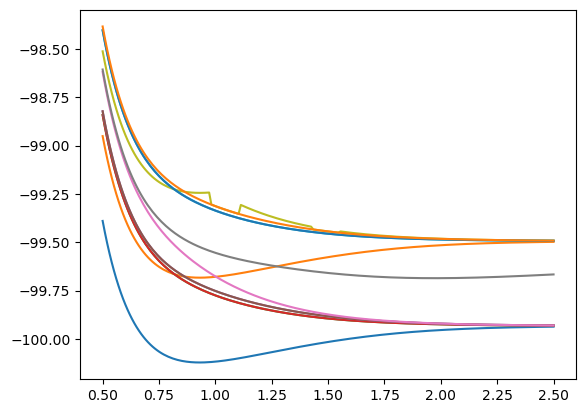

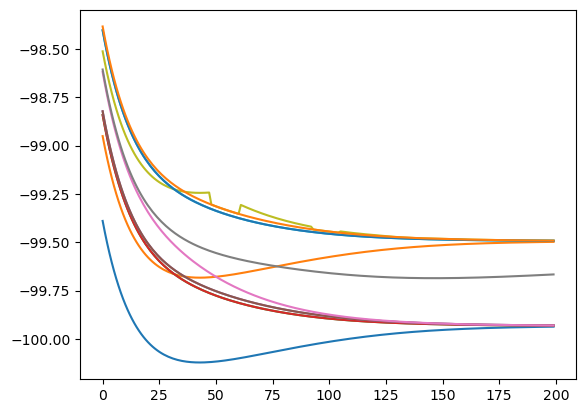

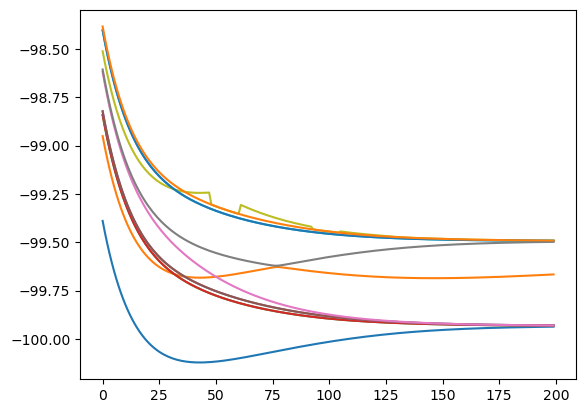

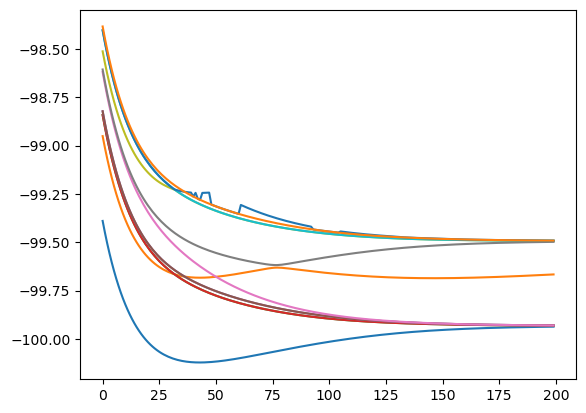

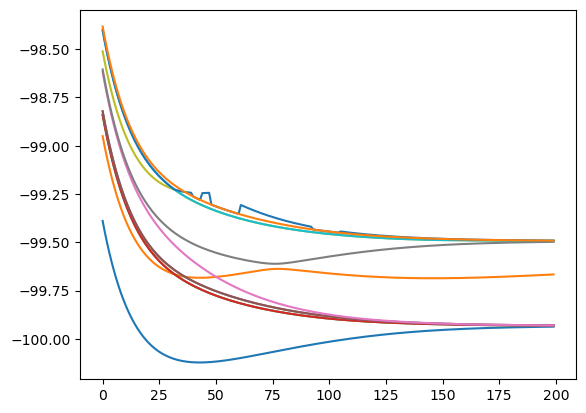

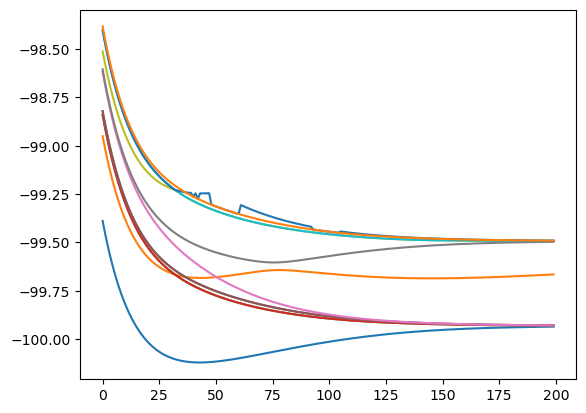

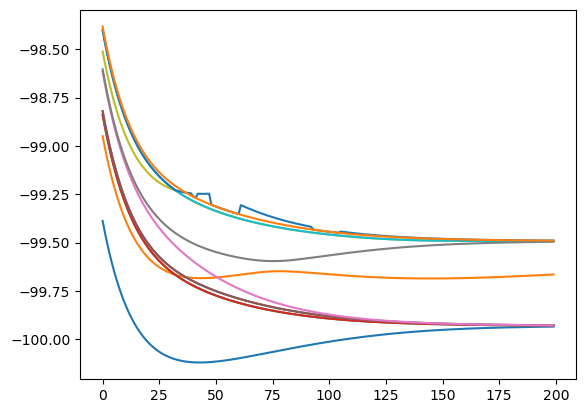

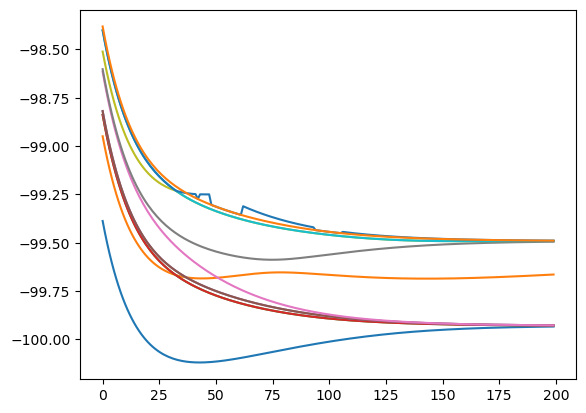

In [ ]:
plt.plot( r_data , cavity_E_array_0_00)
plt.show()
plt.plot(cavity_E_array_0_001)
plt.show()
plt.plot(cavity_E_array_0_005)
plt.show()
plt.plot(cavity_E_array_0_01)
plt.show()
plt.plot(cavity_E_array_0_02)
plt.show()
plt.plot(cavity_E_array_0_03)
plt.show()
plt.plot(cavity_E_array_0_04)
plt.show()
plt.plot(cavity_E_array_0_05)
plt.show()

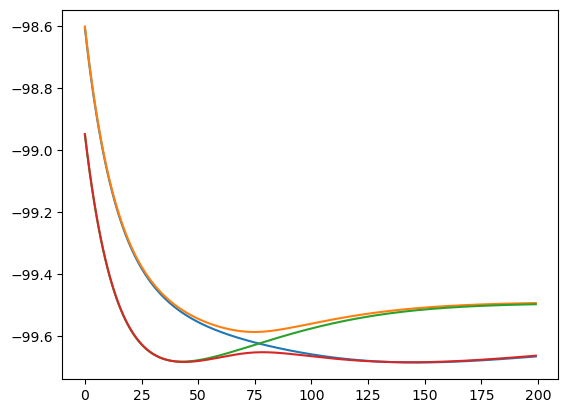

In [ ]:
plt.plot(cavity_E_array_0_00[:,7])
plt.plot(cavity_E_array_0_05[:,7])
plt.plot(cavity_E_array_0_00[:,1])
plt.plot(cavity_E_array_0_05[:,1])


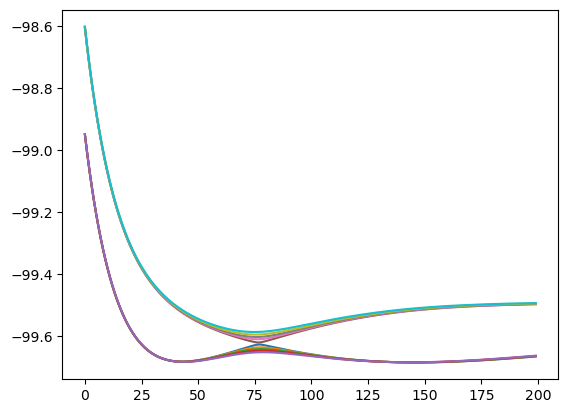

In [ ]:

LP_0_001 =           cavity_E_array_0_001[:,1]
LP_0_005 =            cavity_E_array_0_005[:,1]
LP_0_01 =             cavity_E_array_0_01[:,1]
LP_0_02 =             cavity_E_array_0_02[:,1]
LP_0_03 =             cavity_E_array_0_03[:,1]
LP_0_04 =             cavity_E_array_0_04[:,1]
LP_0_05 =             cavity_E_array_0_05[:,1]
              


UP_0_00 =             cavity_E_array_0_00[:,7]
UP_0_001 =           cavity_E_array_0_001[:,7]
UP_0_005 =            cavity_E_array_0_005[:,7]
UP_0_01 =             cavity_E_array_0_01[:,7]
UP_0_02 =             cavity_E_array_0_02[:,7]
UP_0_03 =             cavity_E_array_0_03[:,7]
UP_0_04 =             cavity_E_array_0_04[:,7]
UP_0_05 =             cavity_E_array_0_05[:,7]
              

S0_array = cavity_E_array_0_00[:,0]
S1_array = cavity_E_array_0_00[:,7]


plt.plot(LP_0_005)
plt.plot(LP_0_02)
plt.plot(LP_0_03)
plt.plot(LP_0_04)
plt.plot(LP_0_05)
plt.plot(UP_0_005)
plt.plot(UP_0_02)
plt.plot(UP_0_03)
plt.plot(UP_0_04)
plt.plot(UP_0_05)
plt.show()

First plot the ground-state potential energy surfaces for $ \text{H2} $ inside and outisde the cavity.  The effect of the cavity will raise the energy slightly.

In [ ]:

hbar = 1

# number of grid points 
N = 2001


def get_fd_wfn(x, V_y: np.array, use_5_point_stencil = False):

    hbar = 1


    # define grid spacing h
    h = x[1]-x[0]

    # create arrays for T, V, and H - we truncate the smallest and largest grid points where 
    # the centered finite difference derivatives cannot be defined
    T = np.zeros((N-2, N-2))
    V = np.zeros((N-2, N-2))
    H = np.zeros((N-2, N-2))

    # this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy


    if not use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -2
                elif np.abs(i-j)==1:
                    T[i,j]=1
                else:
                    T[i,j]=0

        T = -T *( hbar ** 2 / (2 * mu_au* h**2))
        #T =  (- (hbar ** 2) / (2* mu_kg)) *  (1 / ( h**2)) * joule_to_hartree  * T


    elif use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -30
                elif np.abs(i-j)==1:
                    T[i,j]=16
                elif np.abs(i-j)==2:
                    T[i,j]=-1

        T = -T *  ((hbar ** 2) / (2* mu_au))*  (1 / ( 12 * h**2)) 


    for i in range(N-2):
        for j in range(N-2):
            if i==j:
                V[i,j]= V_y[i+1]
            else:
                V[i,j]=0
                
    H = T + V

    #print((-T * hbar ** 2 / (2 * mu_kg* h**2)) * (2.294 * 10 ** 17))
    #print(V)

    vals, vecs = np.linalg.eigh(H)

    if np.average(vecs[:, 0]) < 0:
        vecs = vecs * -1

    return vals, vecs

In [ ]:
#FCF calculator
def get_fcf_matrix(potential_1, potential_2, r_data, matrix_size = 6, potential_1_is_groundstate = False):

    #geneerate 2 sets of wavefunctions for the potentials

    r_data_au = r_data / psi4.constants.bohr2angstroms

    min_potential_1_loc = np.argmin(potential_1[:])
    r_eq_au =r_data_au[potential_1.argmin()]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    poly = np.poly1d(np.polyfit(r_data_au, potential_1, 15))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals1, vecs1 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals1, vecs1 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length (m)')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
    ax1.plot(x[1:N-1], vecs1[:,2], 'g',label = "$\psi_2$")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_1, 'bo', label='PES_1')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    min_potential_2_loc = np.argmin(potential_2[:])
    r_eq_au =r_data_au[min_potential_2_loc]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    #can use this line to only fit to bottom of well for cubic and harmonic
    #poly = np.poly1d(np.polyfit(r_data_meters[50:100], fci_S0[50:100], 4))

    poly = np.poly1d(np.polyfit(r_data_au, potential_2, 15))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals2, vecs2 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals2, vecs2 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs2[:,0], 'r',label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs2[:,1], 'b',label = "$\psi_1$")
    ax1.plot(x[1:N-1], vecs2[:,2], 'g', label = "$\psi_2$")

    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_2, 'bo', label='PES_2')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    FCF_matrix = np.zeros((matrix_size,matrix_size))

    for i in range(FCF_matrix.shape[0]):
        for j in range(FCF_matrix.shape[0]):

            FCF_matrix[i][j] = np.trapz(vecs1[:,i] * vecs2[:,j]) 
            FCF = np.absolute(FCF_matrix) ** 2 

    return FCF



<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:117: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\p'
<>:119: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\p'
<>:54: SyntaxWarning: invalid escape sequence '\p'
<>:117: SyntaxWarning: invalid escape sequence '\p'
<>:118: SyntaxWarning: invalid escape sequence '\p'
<>:119: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/j1g5yyj51l1_gtt0b347d_gwjf45wq/T/ipykernel_71612/3888128518.py:52: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
/var/folders/mb/j1g5yyj51l1_gtt0b347d_gwjf45wq/T/ipykernel_71612/3888128518.py:53: SyntaxWarning: invalid escape sequence '\p'
  ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
/var/folders

r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


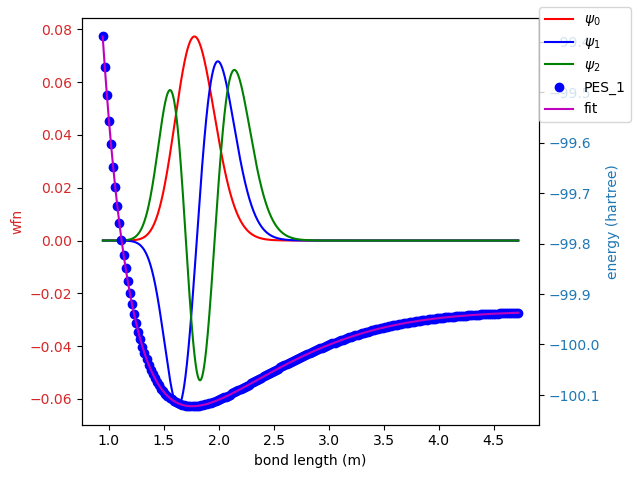

r_eq_au :  2.369279740209689
k_au:  0.3543695554853912


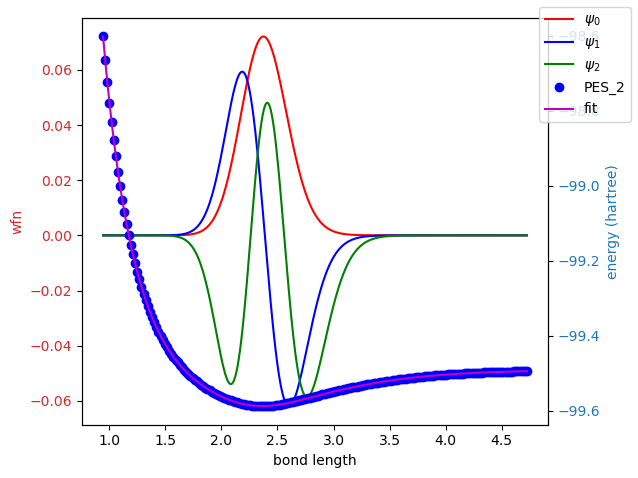

r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


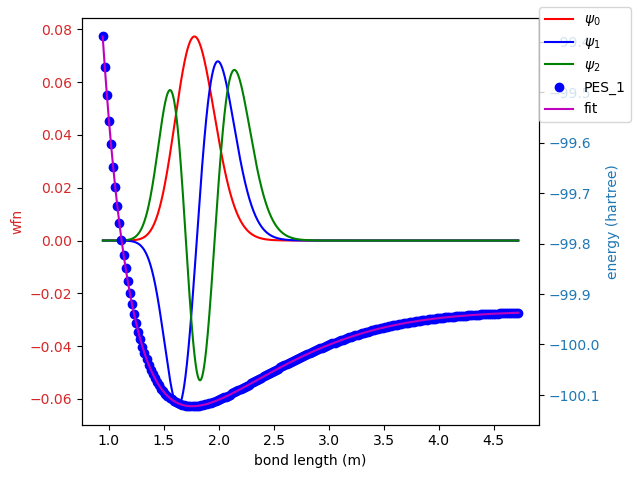

r_eq_au :  2.369279740209689
k_au:  0.4052990172876889


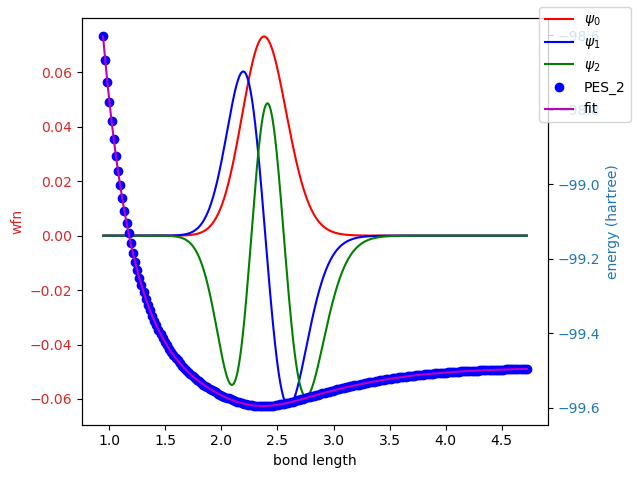

r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


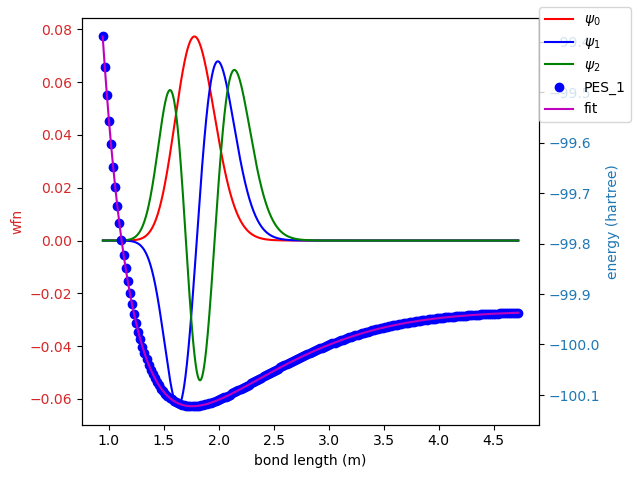

r_eq_au :  2.3882719625760993
k_au:  0.45338162123880466


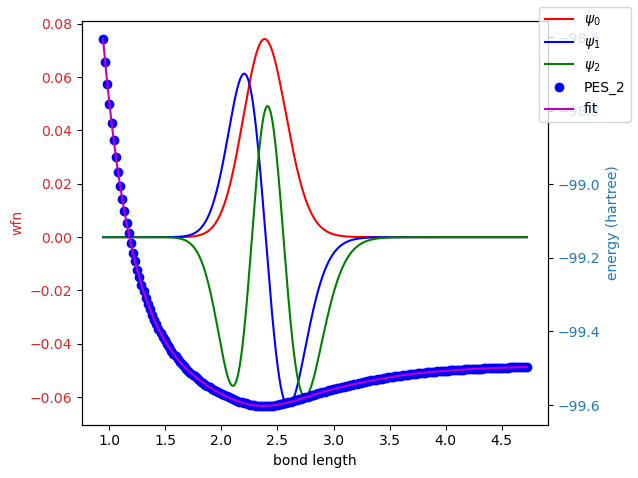

r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


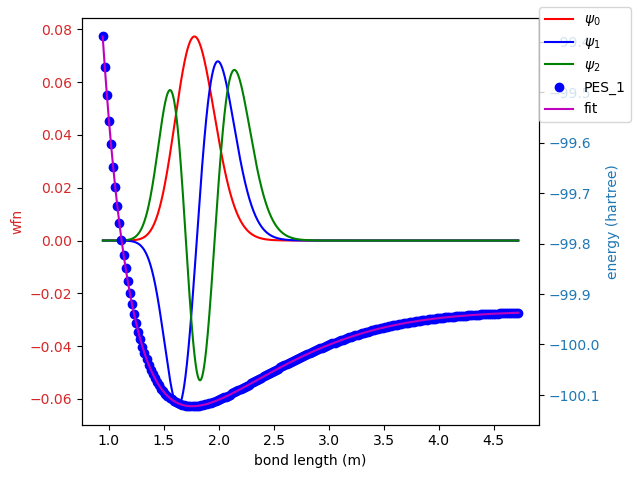

r_eq_au :  2.3882719625760993
k_au:  0.519332532032422


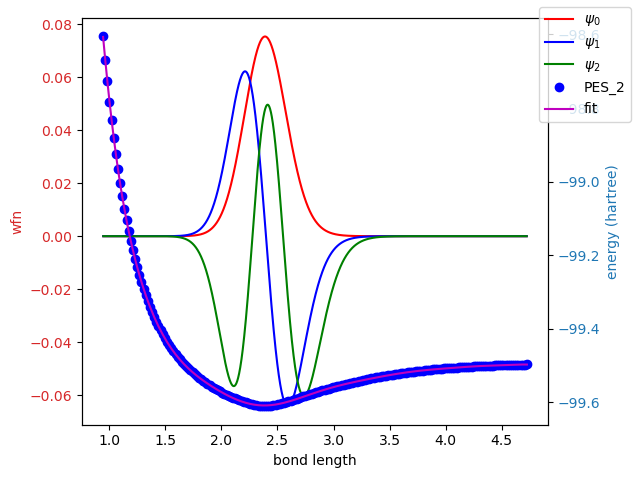

r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


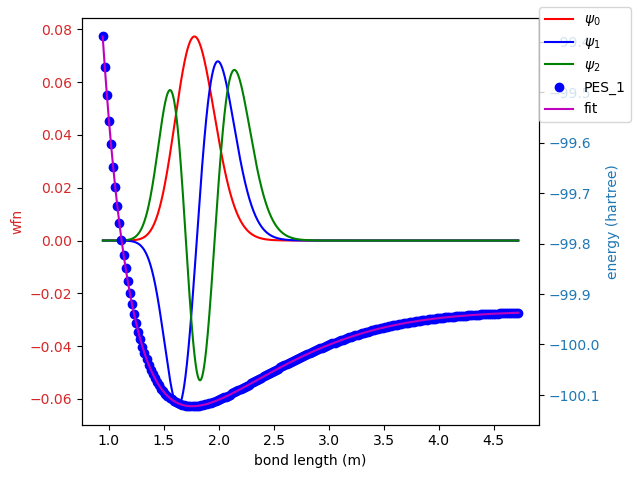

r_eq_au :  2.40726418494251
k_au:  0.6004198172740871


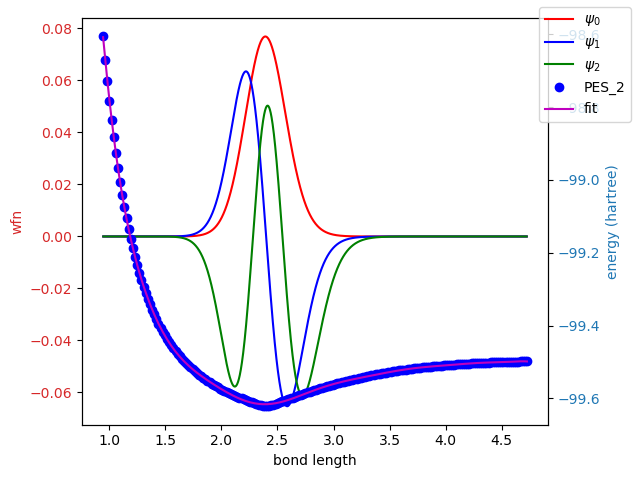

In [ ]:

fcf_0_05 = get_fcf_matrix(S0_array,UP_0_05, r_data, 6)

fcf_0_04 = get_fcf_matrix(S0_array,UP_0_04, r_data, 6)

fcf_0_03 = get_fcf_matrix(S0_array,UP_0_03, r_data, 6)

fcf_0_02 = get_fcf_matrix(S0_array,UP_0_02, r_data, 6)

fcf_0_005 = get_fcf_matrix(S0_array,UP_0_005, r_data, 6)

# fcf_0_001 = get_fcf_matrix(S0_array,UP_0_001, r_data, 6)

In [ ]:
# import seaborn as sns
# min_val, max_val = 0, 15
# cm = sns.light_palette("blue", as_cmap=True)
# x=pd.DataFrame(fcf_0_001)
# x=x.style.background_gradient(cmap=cm)
# display(x)


min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_005)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_02)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_03)
x=x.style.background_gradient(cmap=cm)
display(x)


min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_04)
x=x.style.background_gradient(cmap=cm)
display(x)



min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_05)
x=x.style.background_gradient(cmap=cm)
display(x)

,0,1,2,3,4,5
0,0.005024,0.021956,0.052318,0.085736,0.107641,0.115876
1,0.050370,0.118180,0.147802,0.117537,0.061682,0.019771
2,0.195743,0.174715,0.060683,0.001382,0.014926,0.042803
3,0.358551,0.027734,0.021035,0.070316,0.050633,0.013341
4,0.299240,0.102300,0.090200,0.008886,0.009568,0.036183
5,0.087538,0.369208,0.011455,0.061185,0.036347,0.002832


,0,1,2,3,4,5
0,0.006125,0.025706,0.058138,0.091085,0.111270,0.116813
1,0.056627,0.127570,0.150103,0.112027,0.054748,0.015137
2,0.204811,0.172513,0.051090,0.000142,0.020438,0.048009
3,0.354358,0.022243,0.028668,0.075688,0.048359,0.010051
4,0.286829,0.106727,0.093361,0.006074,0.013908,0.041107
5,0.086984,0.356194,0.010795,0.070668,0.036614,0.001543


,0,1,2,3,4,5
0,0.007270,0.029306,0.063350,0.095561,0.113780,0.116832
1,0.062742,0.135521,0.150972,0.106454,0.048618,0.011661
2,0.213310,0.169030,0.042889,0.000097,0.025374,0.051599
3,0.350863,0.017369,0.035938,0.079358,0.045620,0.007571
4,0.275571,0.112002,0.094616,0.004013,0.017929,0.044566
5,0.085216,0.346148,0.010822,0.078015,0.036440,0.000808


,0,1,2,3,4,5
0,0.008735,0.033575,0.069122,0.100182,0.115904,0.116128
1,0.070061,0.143800,0.150767,0.099796,0.042110,0.008472
2,0.222864,0.163769,0.034418,0.001085,0.030736,0.054617
3,0.346867,0.012389,0.044290,0.082316,0.042164,0.005322
4,0.263121,0.118659,0.094683,0.002249,0.022416,0.047587
5,0.082475,0.336181,0.011243,0.085087,0.036011,0.000326


,0,1,2,3,4,5
0,0.010558,0.038472,0.075268,0.104684,0.117431,0.114598
1,0.078527,0.151984,0.149279,0.092275,0.035604,0.005770
2,0.233108,0.156707,0.026209,0.003186,0.036175,0.056828
3,0.342280,0.007784,0.053374,0.084258,0.038228,0.003469
4,0.249901,0.126482,0.093449,0.000947,0.027083,0.049989
5,0.078933,0.326574,0.012049,0.091506,0.035410,0.000081


r_eq_au :  1.7615286244845585
k_au:  0.5874782705102461


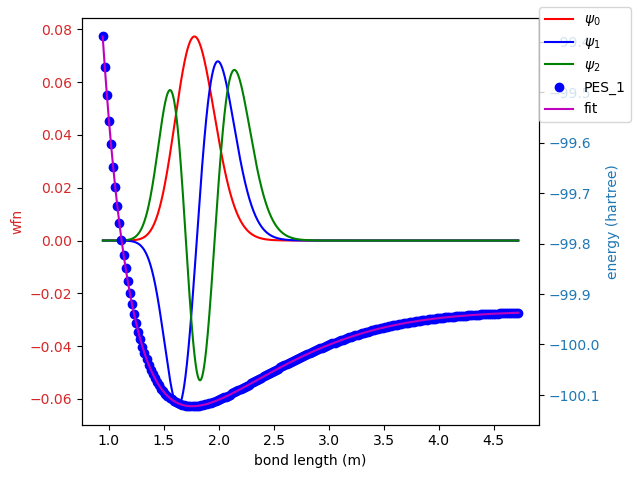

r_eq_au :  3.7177275282248226
k_au:  0.05695731259584136


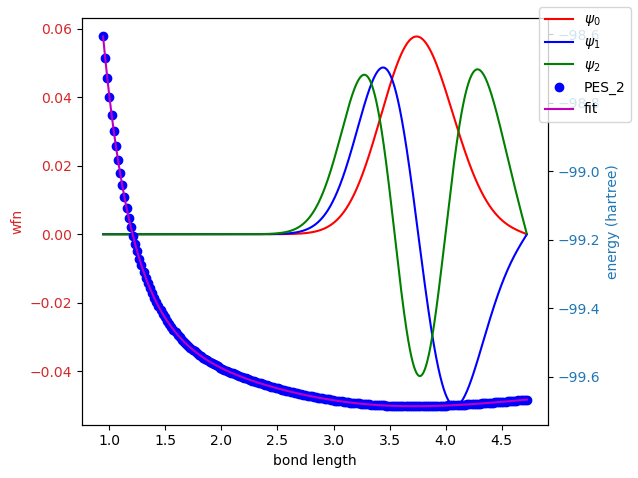

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000001,0.000009,0.000049,0.000231,0.000903
1,0.000000,0.000000,0.000000,0.000000,0.000001,0.000006,0.000038,0.000207,0.000937,0.003480,0.010545
2,0.000000,0.000000,0.000000,0.000002,0.000015,0.000094,0.000501,0.002191,0.007739,0.021790,0.048248
3,0.000000,0.000000,0.000004,0.000028,0.000176,0.000922,0.003917,0.013215,0.034698,0.069109,0.100384
4,0.000000,0.000006,0.000046,0.000283,0.001448,0.005983,0.019370,0.047656,0.085620,0.105000,0.075735
5,0.000005,0.000063,0.000410,0.002051,0.008255,0.025776,0.059767,0.097231,0.100048,0.049524,0.001826
6,0.000055,0.000521,0.002718,0.010649,0.032144,0.070672,0.104591,0.089648,0.027330,0.001675,0.045085
7,0.000443,0.003281,0.013214,0.038446,0.080371,0.108717,0.076896,0.011739,0.012195,0.060086,0.037576
8,0.002830,0.015567,0.045393,0.089524,0.110677,0.063704,0.002876,0.027685,0.064249,0.017138,0.009750
9,0.014219,0.053502,0.101191,0.112148,0.051090,0.000002,0.044397,0.059077,0.003496,0.028482,0.043755


In [ ]:

fcf_S0_S1 = get_fcf_matrix(S0_array,S1_array, r_data, 11)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_S0_S1)
x=x.style.background_gradient(cmap=cm)
display(x)


In [ ]:

from html2image import Html2Image
hti = Html2Image()
hti.screenshot(x.to_html(), save_as = 'FCF_for_HF_ground_to_1_Delta.png')


111320 bytes written to file /Users/proden/Code/SCQED-PCQED/src/FCF_for_HF_ground_to_1_Delta.png


['/Users/proden/Code/SCQED-PCQED/src/FCF_for_HF_ground_to_1_Delta.png']